
                                                                     
#                                                                   Data Loading


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
base_dir = '/content/drive/My Drive/Train'
low_dir = os.path.join(base_dir, 'low')
high_dir = os.path.join(base_dir, 'high')

In [4]:
low_files = [os.path.join(low_dir, file) for file in os.listdir(low_dir)]
high_files = [os.path.join(high_dir, file) for file in os.listdir(high_dir)]

In [5]:
paired_files = []
for low_file in low_files:
    low_filename = os.path.basename(low_file)
    matching_high_file = os.path.join(high_dir, low_filename)
    if os.path.exists(matching_high_file):
        paired_files.append((low_file, matching_high_file))

In [6]:
total_samples = len(paired_files)
print(total_samples)
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

486


In [7]:
import os
import cv2
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
train_low_files, valtest_low_files = train_test_split(low_files, test_size=(val_ratio + test_ratio), random_state=42)
val_low_files, test_low_files = train_test_split(valtest_low_files, test_size=test_ratio/(val_ratio + test_ratio), random_state=42)

train_high_files = [os.path.join(high_dir, os.path.basename(file)) for file in train_low_files]
val_high_files = [os.path.join(high_dir, os.path.basename(file)) for file in val_low_files]
test_high_files = [os.path.join(high_dir, os.path.basename(file)) for file in test_low_files]

def load_and_preprocess_image(file_path):
    image = Image.open(file_path).convert('RGB')  # Ensure the image is in RGB format
    image = image.resize((256, 256))  # Resize to a fixed size if needed
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image
def load_images(image_files):
    filtered_files = [file for file in image_files if not os.path.basename(file).startswith('.')]
    return [load_and_preprocess_image(file) for file in filtered_files]
# def load_images(image_files):
#     return [load_and_preprocess_image(file) for file in image_files]

# Load and preprocess the data
train_low_images = load_images(train_low_files)
train_high_images = load_images(train_high_files)
val_low_images = load_images(val_low_files)
val_high_images = load_images(val_high_files)
test_low_images = load_images(test_low_files)
test_high_images = load_images(test_high_files)

# def display_pairs(low_images, high_images, title):
#     plt.figure(figsize=(10, 4))
#     for i in range(2):
#         plt.subplot(2, 2, i*2 + 1)
#         low_img = cv2.imread(low_images[i])
#         low_img = cv2.cvtColor(low_img, cv2.COLOR_BGR2RGB)
#         plt.imshow(low_img)
#         plt.title('Low Quality')
#         plt.axis('off')

#         plt.subplot(2, 2, i*2 + 2)
#         high_img = cv2.imread(high_images[i])
#         high_img = cv2.cvtColor(high_img, cv2.COLOR_BGR2RGB)
#         plt.imshow(high_img)
#         plt.title('High Quality')
#         plt.axis('off')
#     plt.suptitle(title)
#     plt.show()

# # Display images for training set
# display_pairs(train_low_images[:10], train_high_images[:10], title='Training Set')

# # Display images for validation set
# display_pairs(val_low_images[:10], val_high_images[:10], title='Validation Set')

# # Display images for testing set
# display_pairs(test_low_images[:10], test_high_images[:10], title='Testing Set')


# Convert the images to numpy arrays
train_low_images = np.array(train_low_images)
train_high_images = np.array(train_high_images)
val_low_images = np.array(val_low_images)
val_high_images = np.array(val_high_images)


# Model Structure

In [8]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,\
                                    GlobalAveragePooling2D, AveragePooling2D, MaxPool2D, UpSampling2D,\
                                    BatchNormalization, Activation, Flatten, Dense, Input,\
                                    Add, Multiply, Concatenate, concatenate, Softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import softmax

tf.keras.backend.set_image_data_format('channels_last')

In [9]:
class Convolutional_block(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_2 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_3 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_4 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')

    def call(self, X):
        X_1 = self.conv_1(X)
        X_1 = Activation('relu')(X_1)

        X_2 = self.conv_2(X_1)
        X_2 = Activation('relu')(X_2)

        X_3 = self.conv_3(X_2)
        X_3 = Activation('relu')(X_3)

        # X_4 = self.conv_4(X_3)
        # X_4 = Activation('relu')(X_4)

        #print('---conv block=',X_4.shape)

        return X_3

In [10]:
class Channel_attention(tf.keras.layers.Layer):
    def __init__(self, C=64, **kwargs):
        super().__init__(**kwargs)
        self.C = C
        self.gap = GlobalAveragePooling2D()
        self.dense_middle = Dense(units=2, activation='relu')
        self.dense_sigmoid = Dense(units=self.C, activation='sigmoid')

    def get_config(self):
        config = super().get_config().copy()
        config.update({'C': self.C})
        return config

    def call(self, X):
        v = self.gap(X)
        fc1 = self.dense_middle(v)
        mu = self.dense_sigmoid(fc1)
        mu = tf.reshape(mu, [-1, 1, 1, self.C])  # Adjust shape for multiplication
        U_out = Multiply()([X, mu])
        return U_out



In [11]:
class Spatial_attention(tf.keras.layers.Layer):
    def _init_(self, **kwargs):
        super()._init_(**kwargs)
        self.conv1 = Conv2D(filters=1, kernel_size=(7, 7), padding='same', activation='sigmoid')

    def call(self, X):
        avg_pool = tf.reduce_mean(X, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(X, axis=-1, keepdims=True)
        concat = Concatenate()([avg_pool, max_pool])
        attention = self.conv1(concat)
        return Multiply()([X, attention])


In [12]:
class Avg_pool_Unet_Upsample_msfe(tf.keras.layers.Layer):
    def __init__(self, pool_size, upsample_rate, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
        self.upsample_rate = upsample_rate
        self.avg_pool = AveragePooling2D(pool_size=pool_size, padding='same')
        self.upsample = UpSampling2D(upsample_rate, interpolation='bilinear')
        self.conv_3 = Conv2D(filters=3, kernel_size=[1, 1])

        # Initialize convolutional layers for U-Net
        self.conv_down_layers = []
        self.conv_up_layers = []

        filter_size = 64
        for i in range(4):
            self.conv_down_layers.append([
                Conv2D(filters=filter_size, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
                Conv2D(filters=filter_size, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))
            ])
            filter_size *= 2
            filter_size //= 2
        for i in range(4):
            self.conv_up_layers.append([
                Conv2DTranspose(filters=filter_size, kernel_size=(3, 3), strides=2, padding='same'),
                Conv2D(filters=filter_size, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
                Conv2D(filters=filter_size, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))
            ])
            filter_size //= 2

    def get_config(self):
        config = super().get_config().copy()
        config.update({'avg_pool_size': self.avg_pool_size, 'upsample_rate': self.upsample_rate})
        return config

    def call(self, X):
        # Apply average pooling
        X = self.avg_pool(X)

        # Downsampling path
        conv1 = X
        for conv in self.conv_down_layers:
            conv1 = conv[0](conv1)
            conv1 = conv[1](conv1)
            conv1 = MaxPool2D(pool_size=(2, 2), padding='same')(conv1)

        # Upsampling path
        for conv in self.conv_up_layers:
            conv1 = conv[0](conv1)
            conv1 = conv[1](conv1)
            conv1 = conv[2](conv1)

        # Final convolution and upsampling
        conv1 = self.conv_3(conv1)
        X = self.upsample(conv1)
        return X

In [13]:
class Multi_scale_feature_extraction(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.msfe_16 = Avg_pool_Unet_Upsample_msfe(pool_size=16, upsample_rate=16)
        self.msfe_8 = Avg_pool_Unet_Upsample_msfe(pool_size=8, upsample_rate=8)
        self.msfe_4 = Avg_pool_Unet_Upsample_msfe(pool_size=4, upsample_rate=4)
        self.msfe_2 = Avg_pool_Unet_Upsample_msfe(pool_size=2, upsample_rate=2)
        self.msfe_1 = Avg_pool_Unet_Upsample_msfe(pool_size=1, upsample_rate=1)

    def call(self, X):
        up_sample_16 = self.msfe_16(X)
        up_sample_8 = self.msfe_8(X)
        up_sample_4 = self.msfe_4(X)
        up_sample_2 = self.msfe_2(X)
        up_sample_1 = self.msfe_1(X)
        msfe_out = Concatenate()([X, up_sample_16, up_sample_8, up_sample_4,up_sample_2])

        #print('---Multi scale feature extraction block=',msfe_out.shape)
        return msfe_out

In [14]:
class Kernel_selecting_module(tf.keras.layers.Layer):
    def __init__(self, C=21, **kwargs):
        super().__init__(**kwargs)
        self.C = C
        self.c_3 = Conv2D(filters=self.C, kernel_size=(3,3), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.c_5 = Conv2D(filters=self.C, kernel_size=(5,5), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.c_7 = Conv2D(filters=self.C, kernel_size=(7,7), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.gap = GlobalAveragePooling2D()
        self.dense_two = Dense(units=2, activation='relu')
        self.dense_c1 = Dense(units=self.C)
        self.dense_c2 = Dense(units=self.C)
        self.dense_c3 = Dense(units=self.C)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'C': self.C
        })
        return config

    def call(self, X):
        X_1 = self.c_3(X)
        X_2 = self.c_5(X)
        X_3 = self.c_7(X)

        X_dash = Add()([X_1, X_2, X_3])

        v_gap = self.gap(X_dash)
        v_gap = tf.reshape(v_gap, [-1, 1, 1, self.C])
        fc1 = self.dense_two(v_gap)

        alpha = self.dense_c1(fc1)
        beta = self.dense_c2(fc1)
        gamma = self.dense_c3(fc1)

        before_softmax = concatenate([alpha, beta, gamma], 1)
        # print(before_softmax.shape)
        after_softmax = softmax(before_softmax, axis=1)
        a1 = after_softmax[:, 0, :, :]
        # print(a1)
        a1 = tf.reshape(a1, [-1, 1, 1, self.C])
        # print(a1)
        a2 = after_softmax[:, 1, :, :]
        a2 = tf.reshape(a2, [-1, 1, 1, self.C])
        a3 = after_softmax[:, 2, :, :]
        a3 = tf.reshape(a3, [-1, 1, 1, self.C])

        select_1 = Multiply()([X_1, a1])
        select_2 = Multiply()([X_2, a2])
        select_3 = Multiply()([X_3, a3])

        out = Add()([select_1, select_2, select_3])

        return out

Input = (None, 256, 256, 3)
Conv block = (None, 256, 256, 64)
Channel Attention = (None, 256, 256, 64)
Channel Attention Last CNN = (None, 256, 256, 3)
First phase = (None, 256, 256, 6)

Multi-scale feature extraction = (None, 256, 256, 18)
Kernel Selection Module = (None, 256, 256, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 convolutional_block (Convo  (None, 256, 256, 64)         75648     ['input_layer[0][0]']         
 lutional_block)                                                                                  
                                                                                                  
 chan

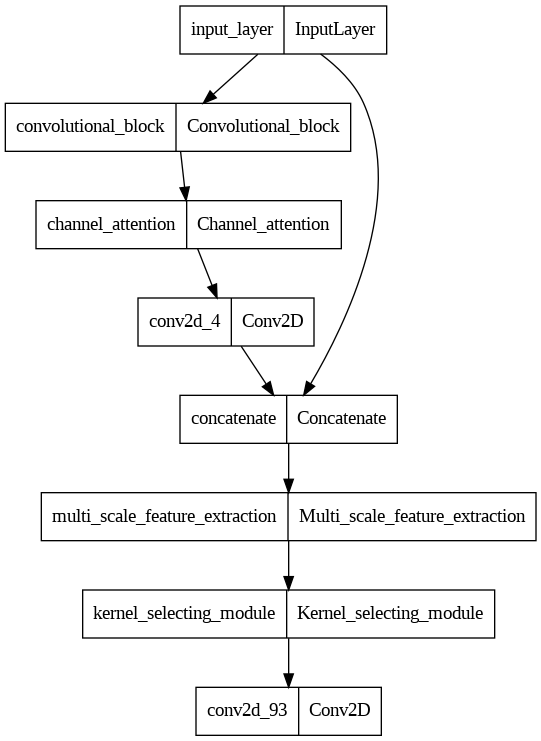

In [15]:
def create_model():
    # ca_block = Channel Attention block
    # msfe_block = Multi scale feature extraction block
    # ksm = Kernel Selecting Module
    tf.keras.backend.clear_session()

    input = Input(shape=(256,256,3), name="input_layer")
    print("Input =",input.shape)

    conv_block = Convolutional_block()(input)
    print("Conv block =",conv_block.shape)
    ca_block = Channel_attention()(conv_block)
    print("Channel Attention =",ca_block.shape)
    ca_block = Conv2D(filters=3, kernel_size=(3,3), strides=1, padding='same')(ca_block)
    print("Channel Attention Last CNN =",ca_block.shape)
    ca_block = Concatenate()([input, ca_block])
    print("First phase =",ca_block.shape)
    print()

    msfe_block = Multi_scale_feature_extraction()(ca_block)

    print("Multi-scale feature extraction =",msfe_block.shape)

    ksm = Kernel_selecting_module()(msfe_block)
    ksm = Conv2D(filters=3, kernel_size=(3,3), strides=1, padding='same')(ksm)
    print("Kernel Selection Module =",ksm.shape)
    model = Model(inputs=[input], outputs=[ksm])
    return model

model = create_model()
# model1=create_model()
# model1.summary()
model.summary()
from tensorflow.keras.utils import plot_model

# Assuming you have your PRIDNet model defined as `model`
plot_model(model)

# losses functions

In [16]:
def color_constancy_loss(x):
    mean_rgb = tf.reduce_mean(x, axis=(1,2) ,keepdims=True)
    mr, mg, mb =mean_rgb[:, :, :, 0], mean_rgb[:, :, :, 1],mean_rgb[:, :, :, 2]
    d_rg=tf.square(mr - mg)
    d_rb=tf.square(mr - mb)
    d_gb=tf.square(mb - mg)
    return tf.sqrt(tf.square(d_rg) + tf.square(d_rb) + tf.square(d_gb))

In [17]:
def exposure_loss(x, mean_val=0.6):
    x=tf.reduce_mean(x, axis=3, keepdims=True)
    mean=tf.nn.avg_pool2d(x, ksize=16, strides=16, padding="VALID")
    return tf.reduce_mean(tf.square(mean - mean_val))


In [18]:
def illumination_smoothness_loss(x):
    batch_size=tf.shape(x)[0]
    h_x=tf.shape(x)[1]
    w_x=tf.shape(x)[2]
    count_h=(tf.shape(x)[2]-1)* tf.shape(x)[3]
    count_w = tf.shape(x)[2] * (tf.shape(x)[3] - 1)
    h_tv=tf.reduce_sum(tf.square((x[:, 1:, :, :] - x[:, :h_x - 1, :, :])))
    w_tv=tf.reduce_sum(tf.square((x[:, :, 1:, :] - x[:, :, :w_x - 1, :])))
    batch_size= tf.cast(batch_size, dtype=tf.float32)
    count_h=tf.cast(count_h, dtype=tf.float32)
    count_w=tf.cast(count_w, dtype=tf.float32)
    return 2*(h_tv/ count_h+ w_tv /count_w) / batch_size

In [19]:
import tensorflow as tf
from tensorflow import keras
class SpatialConsitencyLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
       super(SpatialConsitencyLoss,self).__init__(reduction="none")

       self.left_kernel=tf.constant(
           [[[[0,0,0]],[[-1,1,0]],[[0,0,0]]]], dtype=tf.float32
       )
       self.right_kernel=tf.constant(
           [[[[0,0,0]],[[0,1,-1]],[[0,0,0]]]], dtype=tf.float32
       )
       self.up_kernel=tf.constant(
           [[[[0,-1,0]],[[0,1,0]],[[0,0,0]]]], dtype=tf.float32
       )
       self.down_kernel=tf.constant(
           [[[[0,0,0]],[[0,1,0]],[[0,-1,0]]]], dtype=tf.float32
       )

    def call(self, y_true, y_pred):

        original_mean=tf.reduce_mean(y_true,3,keepdims=True)
        enhanced_mean=tf.reduce_mean(y_pred,3,keepdims=True)
        original_pool=tf.nn.avg_pool2d(
            original_mean, ksize=4, strides=4, padding="VALID"
        )
        enhanced_pool=tf.nn.avg_pool2d(
            enhanced_mean, ksize=4, strides=4, padding="VALID"
        )

        d_original_left=tf.nn.conv2d(
            original_pool,self.left_kernel, strides=[1,1,1,1],padding="SAME"
        )
        d_original_right=tf.nn.conv2d(
            original_pool,self.right_kernel, strides=[1,1,1,1],padding="SAME"
        )
        d_original_up=tf.nn.conv2d(
            original_pool,self.up_kernel, strides=[1,1,1,1],padding="SAME"
        )
        d_original_down=tf.nn.conv2d(
            original_pool,self.down_kernel, strides=[1,1,1,1],padding="SAME"
        )
        d_enhanced_left=tf.nn.conv2d(
            enhanced_pool,self.left_kernel, strides=[1,1,1,1],padding="SAME"
        )
        d_enhanced_right=tf.nn.conv2d(
            enhanced_pool,self.right_kernel, strides=[1,1,1,1],padding="SAME"
        )
        d_enhanced_up=tf.nn.conv2d(
            enhanced_pool,self.up_kernel, strides=[1,1,1,1],padding="SAME"
        )
        d_enhanced_down=tf.nn.conv2d(
            enhanced_pool,self.down_kernel, strides=[1,1,1,1],padding="SAME"
        )

        d_left=tf.square(d_original_left-d_enhanced_left)
        d_right=tf.square(d_original_right-d_enhanced_right)
        d_up=tf.square(d_original_up-d_enhanced_up)
        d_down=tf.square(d_original_down-d_enhanced_down)
        return d_left+ d_right+ d_up+ d_down





# Model Training

In [20]:
model.load_weights('/content/drive/My Drive/final_weights.h5')   # Repeatadly loading data and again saving them means increasing number of epochs

In [ ]:
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=Adam(learning_rate=0.0009))
model.fit(train_low_images, train_high_images,
                        batch_size=16,
                        validation_data=(val_low_images,val_high_images),
                        # steps_per_epoch=steps_per_epoch_train,
                        # validation_steps=steps_per_epoch_validation,
                        epochs=150,
                        verbose=1,
                        # callbacks=callbacks_lst
          )
model_save_path = '/content/drive/My Drive/model_weights3.h5'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save model weights
model.save_weights(model_save_path)
print(f'Model weights saved to {model_save_path}')


# Plots and PSNR

In [22]:
test_low_images_np = np.array(test_low_images).astype('float32')

# Reshape test_low_images_np
num_images = len(test_low_images_np)
# test_low_images_np = test_low_images_np.reshape((num_images, 256, 256, 3))

print("Shape of test_low_images_np:", test_low_images_np.shape)

Shape of test_low_images_np: (98, 256, 256, 3)


In [23]:
import matplotlib.pyplot as plt

def plot_results(low_images, high_images, predicted_images):
    num_images = min(len(low_images), 10)
    plt.figure(figsize=(15, 6*num_images))
    for i in range(num_images):
        plt.subplot(num_images, 3, i*3 + 1)
        plt.imshow(low_images[i])
        plt.title("Low Resolution")
        plt.axis('off')

        plt.subplot(num_images, 3, i*3 + 2)
        plt.imshow(high_images[i])
        plt.title("High Resolution")
        plt.axis('off')

        plt.subplot(num_images, 3, i*3 + 3)
        plt.imshow(predicted_images[i])
        plt.title("Predicted")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Predict high-resolution images
# test_low_images = np.array(test_low_images).astype('float32')
# test_low_images_np = np.array(test_low)
predicted_images = model.predict(test_low_images_np)

# Plot results
# plot_results(test_low_images, test_high_images, predicted_images)


4/4 [==============================] - 54s 12s/step


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

def calculate_psnr(high_images, predicted_images):
    psnr_values = []
    for high_image, predicted_image in zip(high_images, predicted_images):
        psnr_value = psnr(high_image, predicted_image, data_range=1)
        psnr_values.append(psnr_value)
    return psnr_values

def plot_results(low_images, high_images, predicted_images, psnr_values):
    num_images = len(low_images)
    num_cols = 10
    num_rows = (num_images + num_cols - 1) // num_cols
    plt.figure(figsize=(15, 6*num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(low_images[i])
        plt.title("Low Resolution")
        plt.axis('off')

        plt.subplot(num_rows, num_cols, num_images + i + 1)
        plt.imshow(high_images[i])
        plt.title("High Resolution")
        plt.axis('off')

        plt.subplot(num_rows, num_cols, 2 * num_images + i + 1)
        plt.imshow(predicted_images[i])
        plt.title("Predicted\nPSNR: {:.2f}".format(psnr_values[i]))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming test_low_images, test_high_images, and predicted_images are defined
# Predict high-resolution images
# test_low_images_np = np.array(test_low_images)
# predicted_images = model.predict(test_low_images_np)

# Calculate PSNR values
psnr_values = calculate_psnr(test_high_images, predicted_images)
avg_psnr = np.mean(psnr_values)
psnr_values1 = calculate_psnr(test_high_images, test_low_images)

# Plot results with PSNR values
# plot_results(test_low_images, test_high_images, predicted_images, psnr_values)

# Return average PSNR

# Looping over the dataset to plot images
for i in range(len(test_low_images)):
    plot_results([test_low_images[i]], [test_high_images[i]], [predicted_images[i]], [psnr_values[i]])

avg_psnr = np.mean(psnr_values)
print(f'Average PSNR: {avg_psnr:.2f}')
# print(psnr_values1)

Output hidden; open in https://colab.research.google.com to view.

## MSE

In [28]:
import numpy as np

def calculate_mse(predicted_image, high_image):
  """
  Calculates the mean squared error (MSE) between two images.

  Args:
      predicted_image: A NumPy array representing the predicted image.
      high_image: A NumPy array representing the high-resolution image.

  Returns:
      The MSE value between the two images.
  """
  # Ensure images have the same shape
  assert predicted_image.shape == high_image.shape, "Images must have the same shape"

  # Calculate squared errors for each pixel
  squared_errors = np.square(predicted_image - high_image)

  # Calculate the mean squared error
  mse = np.mean(squared_errors)

  return mse

def calculate_mse_for_list(predicted_images, high_images):
  """
  Calculates the MSE for each image pair in two lists and returns a list of MSE values.

  Args:
      predicted_images: A list of NumPy arrays representing predicted images.
      high_images: A list of NumPy arrays representing high-resolution images.

  Returns:
      A list of MSE values, one for each image pair.
  """
  # Check if lists have the same length
  assert len(predicted_images) == len(high_images), "Lists must have the same length"

  mse_list = []
  for predicted_image, high_image in zip(predicted_images, high_images):
    mse = calculate_mse(predicted_image, high_image)
    mse_list.append(mse)

  return mse_list

# Assuming you have predicted_images and high_images as NumPy arrays
mse_list = calculate_mse_for_list(predicted_images, test_high_images)

# Print the MSE for each image pair (optional)
for mse in mse_list:
  print(f"MSE: {mse:.4f}")

# Calculate and print the average MSE (optional)
average_mse = np.mean(mse_list)
print(f"Average MSE: {average_mse:.4f}")


MSE: 0.0020
MSE: 0.0043
MSE: 0.0012
MSE: 0.0056
MSE: 0.0024
MSE: 0.0540
MSE: 0.0079
MSE: 0.0022
MSE: 0.0062
MSE: 0.0021
MSE: 0.0173
MSE: 0.0047
MSE: 0.0041
MSE: 0.0163
MSE: 0.0251
MSE: 0.0022
MSE: 0.0065
MSE: 0.0024
MSE: 0.0126
MSE: 0.0023
MSE: 0.0048
MSE: 0.0014
MSE: 0.0364
MSE: 0.0016
MSE: 0.0066
MSE: 0.0022
MSE: 0.0062
MSE: 0.0031
MSE: 0.0536
MSE: 0.0261
MSE: 0.0015
MSE: 0.0084
MSE: 0.0030
MSE: 0.0048
MSE: 0.0070
MSE: 0.0048
MSE: 0.0018
MSE: 0.0093
MSE: 0.0008
MSE: 0.0016
MSE: 0.0152
MSE: 0.0121
MSE: 0.0268
MSE: 0.0070
MSE: 0.0050
MSE: 0.0602
MSE: 0.0639
MSE: 0.0096
MSE: 0.0393
MSE: 0.0025
MSE: 0.0010
MSE: 0.0145
MSE: 0.0299
MSE: 0.0030
MSE: 0.0069
MSE: 0.0013
MSE: 0.0353
MSE: 0.0025
MSE: 0.0188
MSE: 0.0041
MSE: 0.0030
MSE: 0.0037
MSE: 0.0029
MSE: 0.0055
MSE: 0.0029
MSE: 0.0082
MSE: 0.0102
MSE: 0.0022
MSE: 0.0042
MSE: 0.0169
MSE: 0.0054
MSE: 0.0053
MSE: 0.0031
MSE: 0.0115
MSE: 0.0076
MSE: 0.0285
MSE: 0.0047
MSE: 0.0172
MSE: 0.0233
MSE: 0.0013
MSE: 0.0065
MSE: 0.0182
MSE: 0.0089
MSE:

# MAE

In [27]:
import numpy as np

def calculate_mae(predicted_image, high_image):
  """
  Calculates the mean absolute error (MAE) between two images.

  Args:
      predicted_image: A NumPy array representing the predicted image.
      high_image: A NumPy array representing the high-resolution image.

  Returns:
      The MAE value between the two images.
  """
  # Ensure images have the same shape
  assert predicted_image.shape == high_image.shape, "Images must have the same shape"

  # Calculate absolute differences for each pixel
  absolute_differences = np.abs(predicted_image - high_image)

  # Calculate the mean absolute error
  mae = np.mean(absolute_differences)

  return mae

def calculate_mae_for_list(predicted_images, high_images):
  """
  Calculates the MAE for each image pair in two lists and returns a list of MAE values.

  Args:
      predicted_images: A list of NumPy arrays representing predicted images.
      high_images: A list of NumPy arrays representing high-resolution images.

  Returns:
      A list of MAE values, one for each image pair.
  """
  # Check if lists have the same length
  assert len(predicted_images) == len(high_images), "Lists must have the same length"

  mae_list = []
  for predicted_image, high_image in zip(predicted_images, high_images):
    mae = calculate_mae(predicted_image, high_image)
    mae_list.append(mae)

  return mae_list

# Assuming you have predicted_images and high_images as NumPy arrays
mae_list = calculate_mae_for_list(predicted_images, test_high_images)

# Print the MAE for each image pair (optional)
for mae in mae_list:
  print(f"MAE: {mae:.4f}")

# Calculate and print the average MAE (optional)
average_mae = np.mean(mae_list)
print(f"Average MAE: {average_mae:.4f}")


MAE: 0.0360
MAE: 0.0533
MAE: 0.0251
MAE: 0.0697
MAE: 0.0347
MAE: 0.2281
MAE: 0.0691
MAE: 0.0372
MAE: 0.0725
MAE: 0.0370
MAE: 0.1236
MAE: 0.0620
MAE: 0.0478
MAE: 0.1092
MAE: 0.1493
MAE: 0.0327
MAE: 0.0764
MAE: 0.0391
MAE: 0.1003
MAE: 0.0385
MAE: 0.0615
MAE: 0.0325
MAE: 0.1846
MAE: 0.0311
MAE: 0.0729
MAE: 0.0349
MAE: 0.0712
MAE: 0.0403
MAE: 0.2269
MAE: 0.1561
MAE: 0.0318
MAE: 0.0853
MAE: 0.0498
MAE: 0.0553
MAE: 0.0813
MAE: 0.0523
MAE: 0.0331
MAE: 0.0833
MAE: 0.0215
MAE: 0.0313
MAE: 0.1064
MAE: 0.1044
MAE: 0.1498
MAE: 0.0750
MAE: 0.0663
MAE: 0.2357
MAE: 0.2190
MAE: 0.0789
MAE: 0.1948
MAE: 0.0467
MAE: 0.0263
MAE: 0.1159
MAE: 0.1176
MAE: 0.0472
MAE: 0.0754
MAE: 0.0305
MAE: 0.1752
MAE: 0.0360
MAE: 0.1323
MAE: 0.0575
MAE: 0.0417
MAE: 0.0494
MAE: 0.0445
MAE: 0.0643
MAE: 0.0420
MAE: 0.0704
MAE: 0.0895
MAE: 0.0355
MAE: 0.0582
MAE: 0.1179
MAE: 0.0702
MAE: 0.0665
MAE: 0.0432
MAE: 0.0977
MAE: 0.0766
MAE: 0.1576
MAE: 0.0585
MAE: 0.1221
MAE: 0.1500
MAE: 0.0299
MAE: 0.0676
MAE: 0.1284
MAE: 0.0847
MAE: